In [1]:
import math
import torch
from torch import nn, Tensor
from torch.nn import functional as F
import torchvision
from typing import List, Tuple, Dict, Optional
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import matplotlib.pyplot as plt
# from .roi_heads import paste_masks_in_image


@torch.jit._script_if_tracing
def _onnx_paste_masks_in_image_loop(masks, boxes, im_h, im_w):
    res_append = torch.zeros(0, im_h, im_w)
    for i in range(masks.size(0)):
        mask_res = _onnx_paste_mask_in_image(masks[i][0], boxes[i], im_h, im_w)
        mask_res = mask_res.unsqueeze(0)
        res_append = torch.cat((res_append, mask_res))
    return res_append


def paste_masks_in_image(masks, boxes, img_shape, padding=1):
    # type: (Tensor, Tensor, Tuple[int, int], int) -> Tensor
    masks, scale = expand_masks(masks, padding=padding)
    boxes = expand_boxes(boxes, scale).to(dtype=torch.int64)
    im_h, im_w = img_shape

    if torchvision._is_tracing():
        return _onnx_paste_masks_in_image_loop(masks, boxes,
                                               torch.scalar_tensor(im_h, dtype=torch.int64),
                                               torch.scalar_tensor(im_w, dtype=torch.int64))[:, None]
    res = [
        paste_mask_in_image(m[0], b, im_h, im_w)
        for m, b in zip(masks, boxes)
    ]
    if len(res) > 0:
        ret = torch.stack(res, dim=0)[:, None]
    else:
        ret = masks.new_empty((0, 1, im_h, im_w))
    return ret


class ImageList(object):
    """
    Structure that holds a list of images (of possibly
    varying sizes) as a single tensor.
    This works by padding the images to the same size,
    and storing in a field the original sizes of each image
    """

    def __init__(self, tensors: Tensor, image_sizes: List[Tuple[int, int]]):
        """
        Args:
            tensors (tensor)
            image_sizes (list[tuple[int, int]])
        """
        self.tensors = tensors
        self.image_sizes = image_sizes

    def to(self, device: torch.device) -> 'ImageList':
        cast_tensor = self.tensors.to(device)
        return ImageList(cast_tensor, self.image_sizes)


@torch.jit.unused
def _resize_image_and_masks_onnx(image, self_min_size, self_max_size, target):
    # type: (Tensor, float, float, Optional[Dict[str, Tensor]]) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]
    from torch.onnx import operators
    im_shape = operators.shape_as_tensor(image)[-2:]
    min_size = torch.min(im_shape).to(dtype=torch.float32)
    max_size = torch.max(im_shape).to(dtype=torch.float32)
    scale_factor = torch.min(self_min_size / min_size, self_max_size / max_size)

    image = torch.nn.functional.interpolate(
        image[None], scale_factor=scale_factor, mode='bilinear', recompute_scale_factor=True,
        align_corners=False)[0]

    if target is None:
        return image, target

    if "masks" in target:
        mask = target["masks"]
        mask = F.interpolate(mask[:, None].float(), scale_factor=scale_factor, recompute_scale_factor=True)[:, 0].byte()
        target["masks"] = mask
    return image, target


def _resize_image_and_masks(image, self_min_size, self_max_size, target):
    # type: (Tensor, float, float, Optional[Dict[str, Tensor]]) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]
    im_shape = torch.tensor(image.shape[-2:])
    min_size = float(torch.min(im_shape))
    max_size = float(torch.max(im_shape))
    scale_factor = self_min_size / min_size
    if max_size * scale_factor > self_max_size:
        scale_factor = self_max_size / max_size
    image = torch.nn.functional.interpolate(
        image[None], scale_factor=scale_factor, mode='bilinear', recompute_scale_factor=True,
        align_corners=False)[0]

    if target is None:
        return image, target

    if "masks" in target:
        mask = target["masks"]
        mask = F.interpolate(mask[:, None].float(), scale_factor=scale_factor, recompute_scale_factor=True)[:, 0].byte()
        target["masks"] = mask
    return image, target


class GeneralizedRCNNTransform(nn.Module):
    """
    Performs input / target transformation before feeding the data to a GeneralizedRCNN
    model.

    The transformations it perform are:
        - input normalization (mean subtraction and std division)
        - input / target resizing to match min_size / max_size

    It returns a ImageList for the inputs, and a List[Dict[Tensor]] for the targets
    """

    def __init__(self, min_size, max_size, image_mean, image_std):
        super(GeneralizedRCNNTransform, self).__init__()
        if not isinstance(min_size, (list, tuple)):
            min_size = (min_size,)
        self.min_size = min_size
        self.max_size = max_size
        self.image_mean = image_mean
        self.image_std = image_std

    def forward(self,
                images,       # type: List[Tensor]
                targets=None  # type: Optional[List[Dict[str, Tensor]]]
                ):
        # type: (...) -> Tuple[ImageList, Optional[List[Dict[str, Tensor]]]]
        images = [img for img in images]
        if targets is not None:
            # make a copy of targets to avoid modifying it in-place
            # once torchscript supports dict comprehension
            # this can be simplified as as follows
            # targets = [{k: v for k,v in t.items()} for t in targets]
            targets_copy: List[Dict[str, Tensor]] = []
            for t in targets:
                data: Dict[str, Tensor] = {}
                for k, v in t.items():
                    data[k] = v
                targets_copy.append(data)
            targets = targets_copy
        for i in range(len(images)):
            image = images[i]
            target_index = targets[i] if targets is not None else None

            if image.dim() != 3:
                raise ValueError("images is expected to be a list of 3d tensors "
                                 "of shape [C, H, W], got {}".format(image.shape))
            image = self.normalize(image)
            image, target_index = self.resize(image, target_index)
            images[i] = image
            if targets is not None and target_index is not None:
                targets[i] = target_index

        image_sizes = [img.shape[-2:] for img in images]
        images = self.batch_images(images)
        image_sizes_list: List[Tuple[int, int]] = []
        for image_size in image_sizes:
            assert len(image_size) == 2
            image_sizes_list.append((image_size[0], image_size[1]))

        image_list = ImageList(images, image_sizes_list)
        return image_list, targets

    def normalize(self, image):
        if not image.is_floating_point():
            raise TypeError(
                f"Expected input images to be of floating type (in range [0, 1]), "
                f"but found type {image.dtype} instead"
            )
        dtype, device = image.dtype, image.device
        mean = torch.as_tensor(self.image_mean, dtype=dtype, device=device)
        std = torch.as_tensor(self.image_std, dtype=dtype, device=device)
        return (image - mean[:, None, None]) / std[:, None, None]

    def torch_choice(self, k):
        # type: (List[int]) -> int
        """
        Implements `random.choice` via torch ops so it can be compiled with
        TorchScript. Remove if https://github.com/pytorch/pytorch/issues/25803
        is fixed.
        """
        index = int(torch.empty(1).uniform_(0., float(len(k))).item())
        return k[index]

    def resize(self, image, target):
        # type: (Tensor, Optional[Dict[str, Tensor]]) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]
        h, w = image.shape[-2:]
        if self.training:
            size = float(self.torch_choice(self.min_size))
        else:
            # FIXME assume for now that testing uses the largest scale
            size = float(self.min_size[-1])
        if torchvision._is_tracing():
            image, target = _resize_image_and_masks_onnx(image, size, float(self.max_size), target)
        else:
            image, target = _resize_image_and_masks(image, size, float(self.max_size), target)

        if target is None:
            return image, target

        bbox = target["boxes"]
        bbox = resize_boxes(bbox, (h, w), image.shape[-2:])
        target["boxes"] = bbox

        if "keypoints" in target:
            keypoints = target["keypoints"]
            keypoints = resize_keypoints(keypoints, (h, w), image.shape[-2:])
            target["keypoints"] = keypoints
        return image, target

    # _onnx_batch_images() is an implementation of
    # batch_images() that is supported by ONNX tracing.
    @torch.jit.unused
    def _onnx_batch_images(self, images, size_divisible=32):
        # type: (List[Tensor], int) -> Tensor
        max_size = []
        for i in range(images[0].dim()):
            max_size_i = torch.max(torch.stack([img.shape[i] for img in images]).to(torch.float32)).to(torch.int64)
            max_size.append(max_size_i)
        stride = size_divisible
        max_size[1] = (torch.ceil((max_size[1].to(torch.float32)) / stride) * stride).to(torch.int64)
        max_size[2] = (torch.ceil((max_size[2].to(torch.float32)) / stride) * stride).to(torch.int64)
        max_size = tuple(max_size)

        # work around for
        # pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
        # which is not yet supported in onnx
        padded_imgs = []
        for img in images:
            padding = [(s1 - s2) for s1, s2 in zip(max_size, tuple(img.shape))]
            padded_img = torch.nn.functional.pad(img, (0, padding[2], 0, padding[1], 0, padding[0]))
            padded_imgs.append(padded_img)

        return torch.stack(padded_imgs)

    def max_by_axis(self, the_list):
        # type: (List[List[int]]) -> List[int]
        maxes = the_list[0]
        for sublist in the_list[1:]:
            for index, item in enumerate(sublist):
                maxes[index] = max(maxes[index], item)
        return maxes

    def batch_images(self, images, size_divisible=32):
        # type: (List[Tensor], int) -> Tensor
        if torchvision._is_tracing():
            # batch_images() does not export well to ONNX
            # call _onnx_batch_images() instead
            return self._onnx_batch_images(images, size_divisible)

        max_size = self.max_by_axis([list(img.shape) for img in images])
        stride = float(size_divisible)
        max_size = list(max_size)
        max_size[1] = int(math.ceil(float(max_size[1]) / stride) * stride)
        max_size[2] = int(math.ceil(float(max_size[2]) / stride) * stride)

        batch_shape = [len(images)] + max_size
        batched_imgs = images[0].new_full(batch_shape, 0)
        for img, pad_img in zip(images, batched_imgs):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)

        return batched_imgs

    def postprocess(self,
                    result,               # type: List[Dict[str, Tensor]]
                    image_shapes,         # type: List[Tuple[int, int]]
                    original_image_sizes  # type: List[Tuple[int, int]]
                    ):
        # type: (...) -> List[Dict[str, Tensor]]
        if self.training:
            return result
        for i, (pred, im_s, o_im_s) in enumerate(zip(result, image_shapes, original_image_sizes)):
            boxes = pred["boxes"]
            boxes = resize_boxes(boxes, im_s, o_im_s)
            result[i]["boxes"] = boxes
            if "masks" in pred:
                masks = pred["masks"]
                masks = paste_masks_in_image(masks, boxes, o_im_s)
                result[i]["masks"] = masks
            if "keypoints" in pred:
                keypoints = pred["keypoints"]
                keypoints = resize_keypoints(keypoints, im_s, o_im_s)
                result[i]["keypoints"] = keypoints
        return result

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        _indent = '\n    '
        format_string += "{0}Normalize(mean={1}, std={2})".format(_indent, self.image_mean, self.image_std)
        format_string += "{0}Resize(min_size={1}, max_size={2}, mode='bilinear')".format(_indent, self.min_size,
                                                                                         self.max_size)
        format_string += '\n)'
        return format_string


def resize_keypoints(keypoints, original_size, new_size):
    # type: (Tensor, List[int], List[int]) -> Tensor
    ratios = [
        torch.tensor(s, dtype=torch.float32, device=keypoints.device) /
        torch.tensor(s_orig, dtype=torch.float32, device=keypoints.device)
        for s, s_orig in zip(new_size, original_size)
    ]
    ratio_h, ratio_w = ratios
    resized_data = keypoints.clone()
    if torch._C._get_tracing_state():
        resized_data_0 = resized_data[:, :, 0] * ratio_w
        resized_data_1 = resized_data[:, :, 1] * ratio_h
        resized_data = torch.stack((resized_data_0, resized_data_1, resized_data[:, :, 2]), dim=2)
    else:
        resized_data[..., 0] *= ratio_w
        resized_data[..., 1] *= ratio_h
    return resized_data


def resize_boxes(boxes, original_size, new_size):
    # type: (Tensor, List[int], List[int]) -> Tensor
    ratios = [
        torch.tensor(s, dtype=torch.float32, device=boxes.device) /
        torch.tensor(s_orig, dtype=torch.float32, device=boxes.device)
        for s, s_orig in zip(new_size, original_size)
    ]
    ratio_height, ratio_width = ratios
    xmin, ymin, xmax, ymax = boxes.unbind(1)

    xmin = xmin * ratio_width
    xmax = xmax * ratio_width
    ymin = ymin * ratio_height
    ymax = ymax * ratio_height
    return torch.stack((xmin, ymin, xmax, ymax), dim=1)


In [2]:
class RestoreNormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [6]:
def draw_images(path):
    image = Image.open(path).convert('RGB')
    tensor = ToTensor()(image)
    print(tensor.size())

    square = image.resize((550, 550))

    image_list = GeneralizedRCNNTransform(800, 1333, image_mean=[0.485, 0.456, 0.406], image_std=[0.229, 0.224, 0.225])([tensor])
    print(image_list[0].tensors.size())
    tensor = image_list[0].tensors

    tensor = RestoreNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(tensor[0])
    tensor = ToPILImage()(tensor)
    
    fig, axes = plt.subplots(1, 3, dpi=200)
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[1].imshow(tensor)
    axes[1].axis('off')
    axes[2].imshow(square)
    axes[2].axis('off')
    fig.tight_layout()
    plt.show()

torch.Size([3, 1050, 750])
torch.Size([1, 3, 1120, 800])


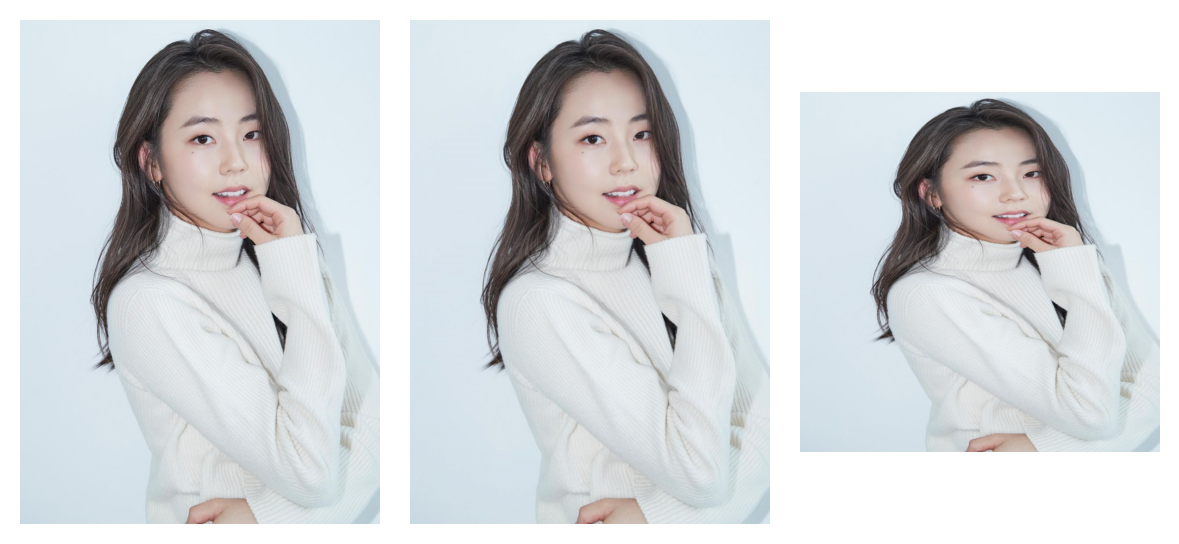

In [7]:
draw_images('sohee01.jpg')

torch.Size([3, 517, 777])
torch.Size([1, 3, 800, 1216])


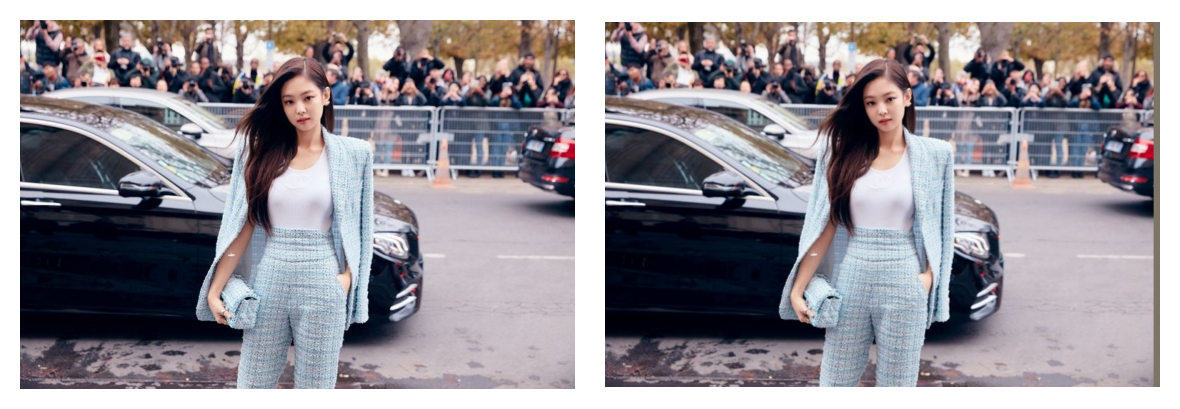

In [67]:
draw_images('jennie01.jpg')